In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import lime
import lime.lime_tabular


In [3]:
df = pd.read_csv('secondary_data.csv',delimiter=';')


In [4]:
# 对所有类别特征进行标签编码
labelencoder = LabelEncoder()
for column in df.columns:
    df[column] = labelencoder.fit_transform(df[column])

# 拆分数据集
X = df.drop('class', axis=1)  # 假设'target'是目标列
y = df['class']

columns_to_drop = ['class','cap-shape','cap-color','gill-color','cap-surface','stem-color', 'gill-attachment', 'gill-spacing', 'stem-root','stem-surface','veil-type','veil-color','ring-type','spore-print-color','habitat']  # 示例列名，请根据实际情况替换

# 删除多个列
X = df.drop(columns=columns_to_drop)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
model = XGBClassifier()
model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [6]:
# import joblib
# model = joblib.load('./xgb_model.joblib')
# 预测并评估模型
y_pred = model.predict(X_train)
y_test_pred= model.predict(X_test)
accuracy = accuracy_score(y_train, y_pred)
print(f'Accuracy: {accuracy}')
print(f'Accuracy: {accuracy_score(y_test, y_test_pred)}')

Accuracy: 0.9003991403131716
Accuracy: 0.886933027673162


In [7]:
import shap
explainer = shap.Explainer(model, X_train)
shap_values = explainer.shap_values(X_train)

100%|===================| 48691/48855 [01:23<00:00]        

In [8]:
test_shap_values = explainer.shap_values(X_test)

100%|===================| 12178/12214 [00:21<00:00]        

In [7]:
max_value = shap_values.max()
min_value = shap_values.min()


In [8]:
max_value

8.719445367625449

In [9]:
min_value

-6.372461072780716

In [9]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.multioutput import MultiOutputClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
# Train the regression model
# 创建 SHAP 值的二元标签
shap_values_array = shap_values
# Define thresholds
max_value = shap_values_array.max()
min_value = shap_values_array.min()

positive_threshold = max_value / 5
negative_threshold = min_value / 5

# Initialize the label array
shap_binary_labels = np.zeros(shap_values_array.shape, dtype=int)

# Assign categories
# shap_binary_labels[shap_values_array > positive_threshold] = 3  # Strong positive
# shap_binary_labels[(shap_values_array > 0) & (shap_values_array <= positive_threshold)] = 1  # Positive
# shap_binary_labels[(shap_values_array < 0) & (shap_values_array >= negative_threshold)] = 0  # Negative
# shap_binary_labels[shap_values_array < negative_threshold] = 2  # Strong negative

shap_binary_labels[shap_values_array > 0] = 1  # Strong positive
shap_binary_labels[shap_values_array < 0] = 0  # Strong negative


# shap_binary_labels = (shap_values_array > 0).astype(int)  # 1 为正，0 为负
# Identify categorical features
categorical_features = ['does-bruise-or-bleed', 'has-ring', 'season']
numerical_features = [col for col in X.columns if col not in categorical_features]

# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)


# Random Forest classifier
# base_clf = RandomForestClassifier(n_estimators=100, random_state=42)

base_clf = DecisionTreeClassifier(random_state=42)
multi_target_clf = MultiOutputClassifier(base_clf, n_jobs=-1)

# Create the pipeline with preprocessing and the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', multi_target_clf)
])


# Train the multi-output classifier
pipeline.fit(X_train.astype(np.float32), shap_binary_labels)

# Evaluate the model on the training set
y_pred_train = pipeline.predict(X_train.astype(np.float32))
# Print classification report for each output
for i in range(shap_binary_labels.shape[1]):
    print(f"Classification Report for Output {i}:")
    print(classification_report(shap_binary_labels[:, i], y_pred_train[:, i]))

# Optionally, you can calculate and print the average accuracy
accuracies = []
for i in range(shap_binary_labels.shape[1]):
    accuracies.append(np.mean(shap_binary_labels[:, i] == y_pred_train[:, i]))

average_accuracy = np.mean(accuracies)
print(f"Average Accuracy: {average_accuracy}")


Classification Report for Output 0:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25603
           1       1.00      1.00      1.00     23252

    accuracy                           1.00     48855
   macro avg       1.00      1.00      1.00     48855
weighted avg       1.00      1.00      1.00     48855

Classification Report for Output 1:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37493
           1       1.00      1.00      1.00     11362

    accuracy                           1.00     48855
   macro avg       1.00      1.00      1.00     48855
weighted avg       1.00      1.00      1.00     48855

Classification Report for Output 2:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     30753
           1       1.00      1.00      1.00     18102

    accuracy                           1.00     48855
   macro avg       1

In [85]:
y_pred_train

array([[1, 0, 0, 0, 1, 1],
       [0, 0, 0, 1, 0, 1],
       [1, 0, 0, 1, 0, 0],
       ...,
       [0, 1, 1, 0, 1, 1],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1]])

In [10]:
test_shap_values_array = test_shap_values
# Initialize the label array
test_shap_binary_labels = np.zeros(test_shap_values_array.shape, dtype=int)

# Assign categories
test_shap_binary_labels[test_shap_binary_labels > 0] = 1  # Strong positive
# test_shap_binary_labels[(test_shap_binary_labels > 0) & (test_shap_binary_labels <= positive_threshold)] = 1  # Positive
# test_shap_binary_labels[(test_shap_binary_labels < 0) & (test_shap_binary_labels >= negative_threshold)] = 0  # Negative
test_shap_binary_labels[test_shap_binary_labels < 0] = 0  # Strong negative


# Evaluate the model on the training set
y_pred_test = pipeline.predict(X_test.astype(np.float32))
# Print classification report for each output
# for i in range(test_shap_binary_labels.shape[1]):
    # print(f"Classification Report for Output {i}:")
    # print(classification_report(test_shap_binary_labels[:, i], y_pred_test[:, i]))

# Optionally, you can calculate and print the average accuracy
accuracies = []
for i in range(test_shap_binary_labels.shape[1]):
    accuracies.append(np.mean(test_shap_binary_labels[:, i] == y_pred_test[:, i]))

average_accuracy = np.mean(accuracies)
print(f"Test Average Accuracy: {average_accuracy}")

Test Average Accuracy: 0.5573658643087168


In [26]:
X_train.iloc[200]

cap-diameter            339
does-bruise-or-bleed      1
stem-height             405
stem-width              576
has-ring                  0
season                    2
Name: 29762, dtype: int64

SHAP Values for Target cap-diameter


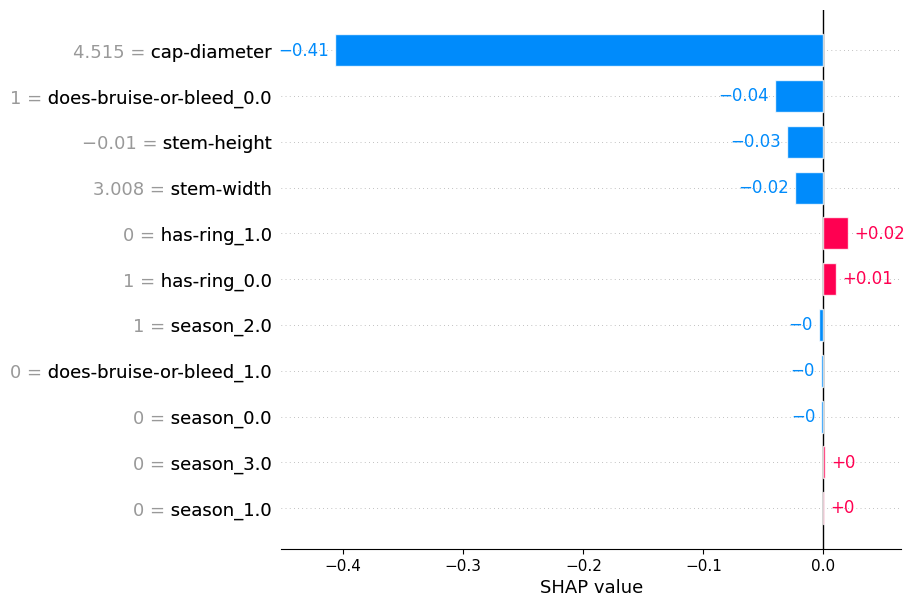

SHAP Values for Target does-bruise-or-bleed


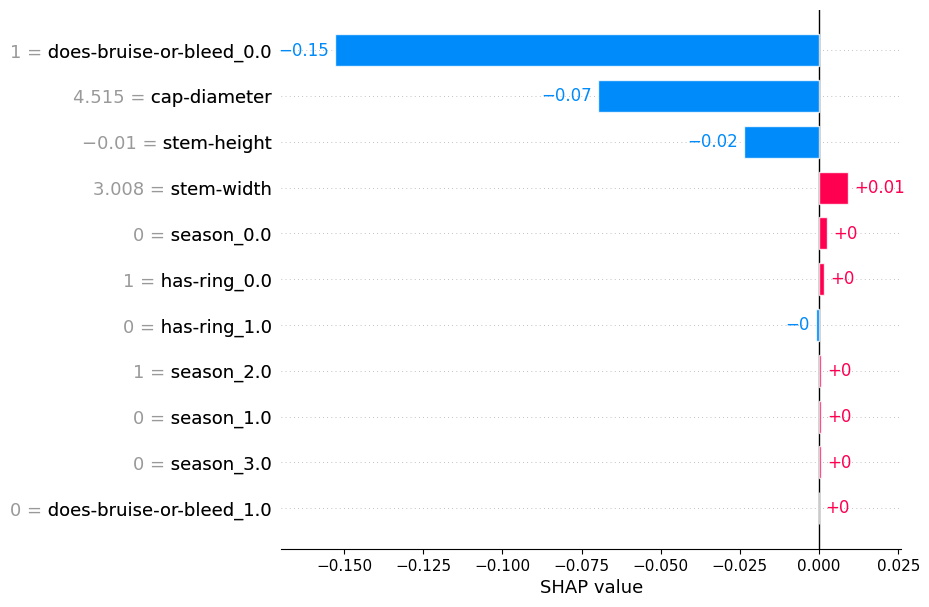

SHAP Values for Target stem-height


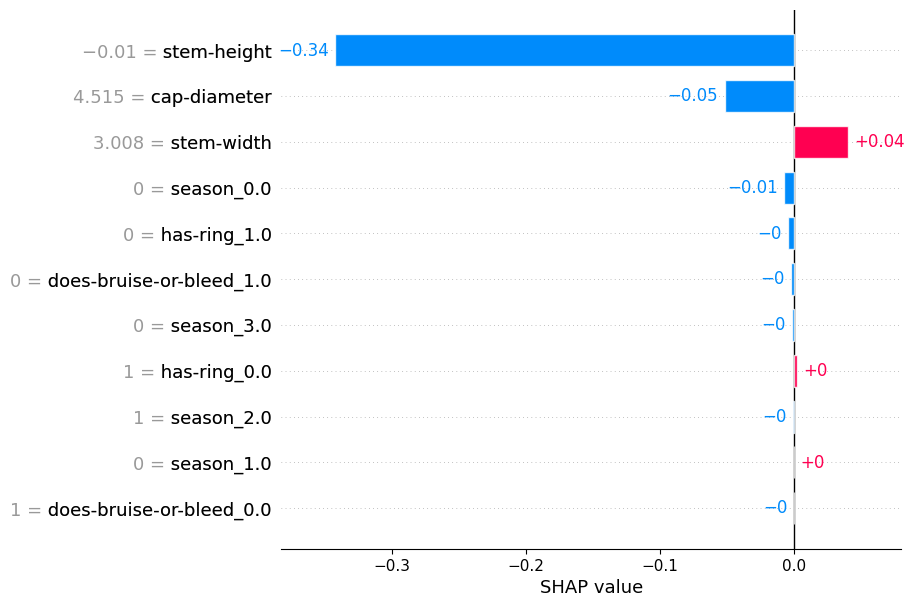

SHAP Values for Target stem-width


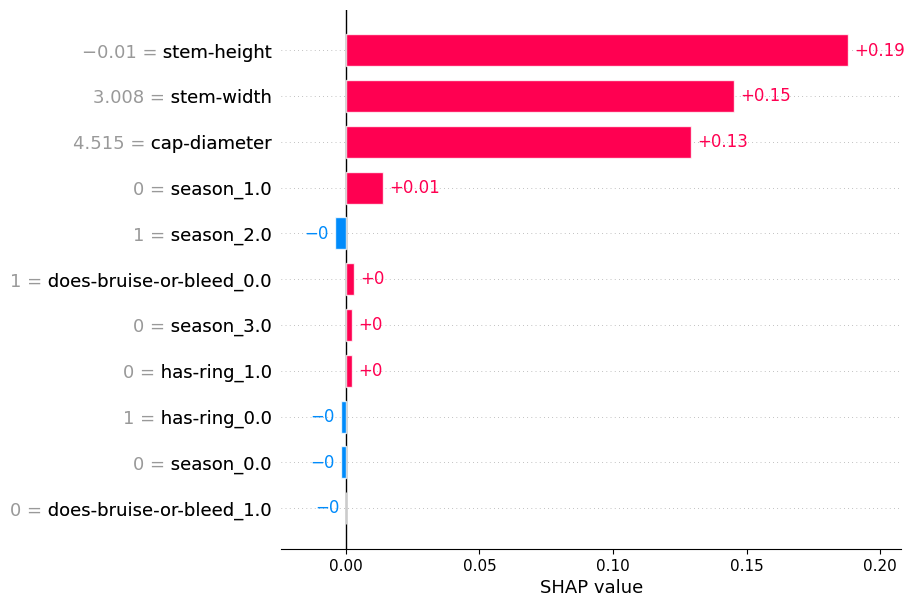

SHAP Values for Target has-ring


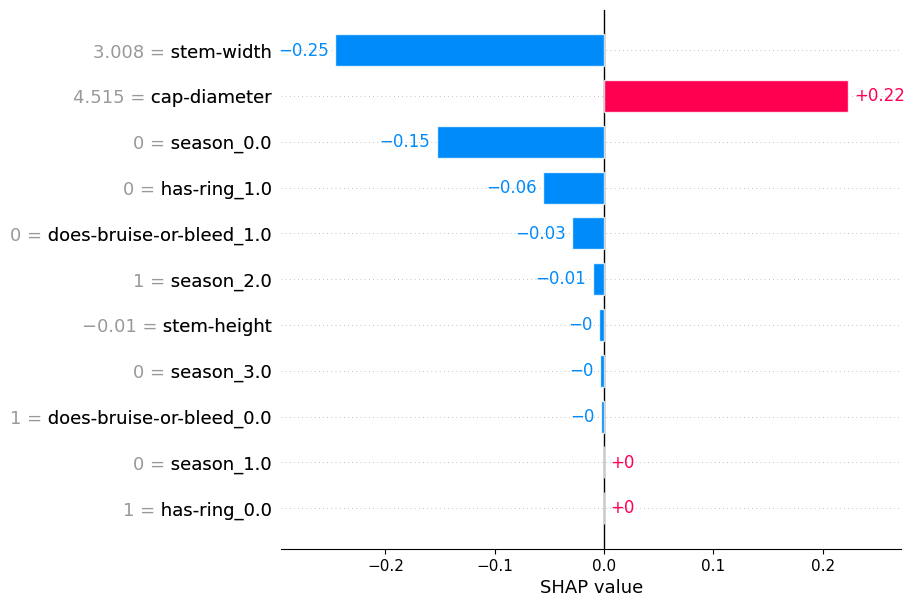

SHAP Values for Target season


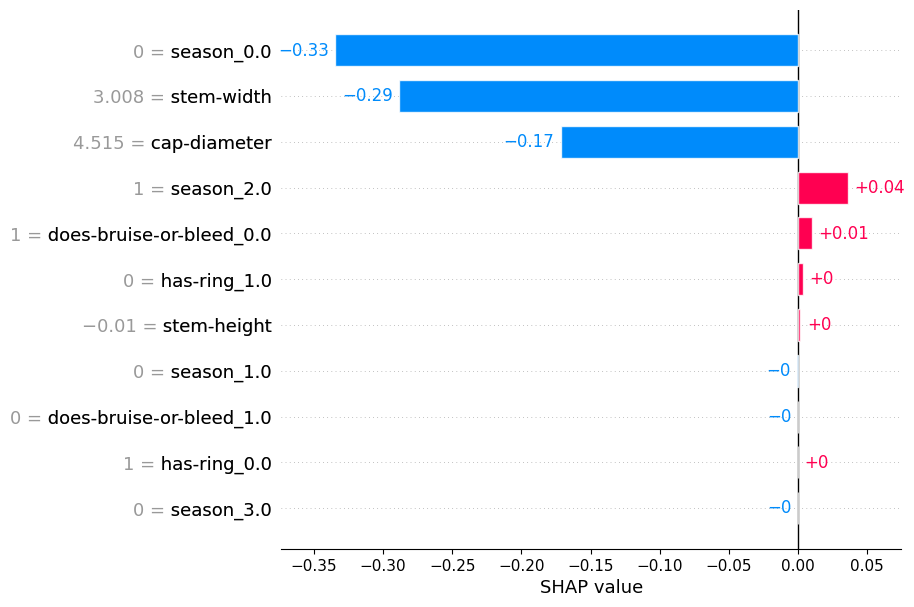

In [43]:
# Calculate SHAP values for the training data using SHAP library
X_train_scaled = preprocessor.transform(X_train.astype(np.float32))
# Generate SHAP values and plots for each output
instance_index = 19
instance_scaled = X_train_scaled[instance_index].reshape(1, -1)

# Define feature names after preprocessing
one_hot_encoder = preprocessor.named_transformers_['cat']
one_hot_feature_names = one_hot_encoder.get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(one_hot_feature_names)

feature_names = [
    'cap-diameter',  
    'does-bruise-or-bleed',
    'stem-height',
    'stem-width',
    'has-ring',
    'season'
]  
# Generate SHAP values for each estimator (one per target variable)
for output_idx, estimator in enumerate(multi_target_clf.estimators_):
    explainer = shap.TreeExplainer(estimator)
    shap_values = explainer(instance_scaled)

    # Select the SHAP values for the specific class (e.g., class 1)
    shap_values_class_1 = shap_values[..., 1] if shap_values.shape[-1] > 1 else shap_values

    # Create SHAP Explanation object
    shap_exp = shap.Explanation(values=shap_values_class_1[0], base_values=explainer.expected_value[1] if explainer.expected_value.size > 1 else explainer.expected_value, data=instance_scaled, feature_names=all_feature_names)
    print(f'SHAP Values for Target {feature_names[output_idx]}')
    # Generate bar plot for the current output
    shap.plots.bar(shap_exp, max_display=len(all_feature_names))
    # plt.title(f'SHAP Values for Target {output_idx}')
    plt.show()

In [21]:
instance_scaled

array([[-0.64159697, -0.44503596, -0.62909067,  0.        ,  1.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ]])

shap_values .values =
array([[[ 0.29416667, -0.29416667],
        [ 0.12283333, -0.12283333],
        [-0.02883333,  0.02883333],
        [-0.011     ,  0.011     ],
        [ 0.04133333, -0.04133333],
        [ 0.0785    , -0.0785    ],
        [-0.00616667,  0.00616667],
        [-0.00066667,  0.00066667],
        [-0.00083333,  0.00083333],
        [ 0.00166667, -0.00166667],
        [-0.001     ,  0.001     ]]])

.base_values =
array([[0.51, 0.49]])

.data =
array([[-0.64159697, -0.44503596, -0.62909067,  0.        ,  1.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ]])


TypeError: 'numpy.float64' object is not iterable

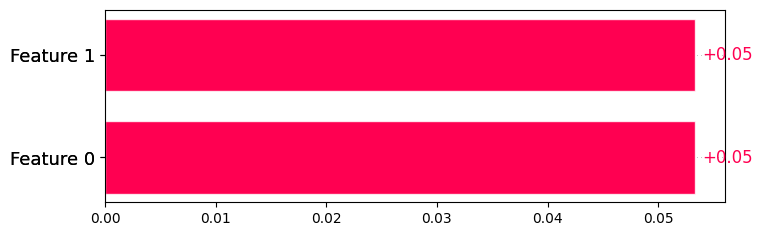

In [19]:
# Calculate SHAP values for the training data using SHAP library
X_train_scaled = preprocessor.transform(X_train.astype(np.float32))

# Generate SHAP values and plots for each output
instance_index = 200
instance_scaled = X_train_scaled[instance_index].reshape(1, -1)

# Define feature names after preprocessing
one_hot_encoder = preprocessor.named_transformers_['cat']
one_hot_feature_names = one_hot_encoder.get_feature_names_out(categorical_features)
feature_names = numerical_features + list(one_hot_feature_names)

for output_idx, estimator in enumerate(multi_target_clf.estimators_):
    explainer = shap.Explainer(estimator, X_train_scaled)
    shap_values = explainer(instance_scaled)
    print("shap_values",shap_values)
    
    # Generate bar plot for the current output
    shap.plots.bar(shap_values[0], max_display=len(feature_names))
    plt.title(f'SHAP Values for {feature_names[output_idx]} SHAP')
    plt.show()

In [92]:
import math
# Select a specific instance (e.g., the first instance in the test set)
instance_index = 8
instance_scaled = pipeline.named_steps['preprocessor'].transform(X_train.iloc[[instance_index]]).astype(np.float32)
instance_original = X_train.iloc[instance_index].values.reshape(1, -1).astype(np.float32)

feature_names = [
    'cap-diameter',  
    'does-bruise-or-bleed',
    'stem-height',
    'stem-width',
    'has-ring',
    'season'
]    


# Initialize the rules dictionary
rules_dict = {feature_name: [] for feature_name in feature_names}

# Get the decision path for the instance and generate natural language explanations
multi_target_clf = pipeline.named_steps['classifier']

# Ensure the data is in the correct dtype
X = X.astype(np.float32)

# Identify numerical and categorical feature indices
numerical_features_indices = [X.columns.get_loc(feature) for feature in numerical_features]
cat_features_indices = [X.columns.get_loc(feature) for feature in categorical_features]

for i, estimator in enumerate(multi_target_clf.estimators_):
    
    node_indicator = estimator.decision_path(instance_scaled)
    leaf_id = estimator.apply(instance_scaled)
    
    feature_indices = estimator.tree_.feature
    impurities = estimator.tree_.impurity
    n_node_samples = estimator.tree_.n_node_samples
    node_depth = estimator.tree_.decision_path(instance_scaled).toarray().sum(axis=0)
    
    # Sort nodes by depth (starting from the root)
    sorted_node_index = sorted(node_indicator.indices[node_indicator.indptr[0]:node_indicator.indptr[1]], key=lambda x: node_depth[x])
    contribution_value = shap_binary_labels[instance_index, i]
    print(y_pred_train[instance_index][i])

    if contribution_value == 1:
            contribution_desc = "positive"
    else:
            contribution_desc = "negative"

    
    print(f"{feature_names[i]}: shap value {contribution_desc}")
    for node_id in sorted_node_index:
        if leaf_id == node_id:
            continue

        # Get the relevant information for the decision node
        feature_index = feature_indices[node_id]
        if feature_index == -2:
            continue

        node_importance = impurities[node_id]
        sample_count = n_node_samples[node_id]

        if feature_index in numerical_features_indices:  # Numerical feature
            feature_name = X.columns[feature_index]
            feature_value_scaled = instance_scaled[0, feature_index]
            feature_value_original = instance_original[0, feature_index]
            
            # Inverse transform to get the original threshold value
            threshold_value_scaled = estimator.tree_.threshold[node_id]
            threshold_value_array = np.zeros((1, len(numerical_features)))
            threshold_value_array[0, numerical_features_indices.index(feature_index)] = threshold_value_scaled
            threshold_value_original = preprocessor.named_transformers_['num'].inverse_transform(threshold_value_array)[0, numerical_features_indices.index(feature_index)]

            if feature_value_original <= threshold_value_original:
                threshold_sign = "<="
            else:
                threshold_sign = ">"  
        elif feature_index in cat_features_indices:  # One-hot encoded categorical feature
            category_index = np.where(cat_features_indices == feature_index)[0]
            if len(category_index) > 0:
                category_index = category_index[0]
                one_hot_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
                one_hot_feature_name = one_hot_feature_names[category_index]
                feature_name, category_name = one_hot_feature_name.split('_', 1)
                feature_value_original = instance_original[0, list(X.columns).index(feature_name)]

                
                threshold_value_original = category_name
                if str(feature_value_original) == str(threshold_value_original):
                    threshold_sign = "="
                else:
                    threshold_sign = "!="
                
            else:
                continue  # If there's no match, skip this node
        if node_importance > 0.0:
            # Add the rule to the dictionary
            rules_dict[feature_names[i]].append((feature_name, feature_value_original, threshold_sign, threshold_value_original, node_importance, sample_count))

            # Generate the natural language explanation
            explanation = (
            f"importance: {node_importance:.2f}"
            f" feature '{feature_name}': {feature_value_original} {threshold_sign} {threshold_value_original}. "
            f" Contributes the prediction: Shap({feature_names[i]})={contribution_desc}. "
            )
            print(explanation)
    
    print("\n")


0
cap-diameter: shap value negative
importance: 0.50 feature 'stem-height': 1447.0 > 307.8127204755664.  Contributes the prediction: Shap(cap-diameter)=negative. 
importance: 0.46 feature 'stem-height': 1447.0 > 1058.973600926653.  Contributes the prediction: Shap(cap-diameter)=negative. 
importance: 0.46 feature 'cap-diameter': 1926.0 <= 2252.499975324781.  Contributes the prediction: Shap(cap-diameter)=negative. 
importance: 0.43 feature 'stem-width': 3231.0 > 1584.9018883638569.  Contributes the prediction: Shap(cap-diameter)=negative. 
importance: 0.48 feature 'does-bruise-or-bleed': 0.0 = 0.0.  Contributes the prediction: Shap(cap-diameter)=negative. 
importance: 0.44 feature 'stem-height': 1447.0 <= 1629.8487465095045.  Contributes the prediction: Shap(cap-diameter)=negative. 
importance: 0.07 feature 'cap-diameter': 1926.0 > 1337.4999781846755.  Contributes the prediction: Shap(cap-diameter)=negative. 
importance: 0.02 feature 'does-bruise-or-bleed': 0.0 = 0.0.  Contributes the 

In [15]:
from collections import defaultdict
# 选择一个特定的实例（例如，测试集中的第一个实例）
instance_index = 0
# instance_scaled = X_train_scaled[instance_index].reshape(1, -1)
instance_original = X_train.iloc[instance_index].values.reshape(1, -1)

instance_original = X_train.iloc[instance_index].values.reshape(1, -1)
instance_scaled = pipeline.named_steps['preprocessor'].transform(X_train.iloc[[instance_index]])


feature_names = [   'cap-diameter',  
                    'does-bruise-or-bleed',
                   'stem-height',
                   'stem-width',
                   'has-ring',
                   'season'
]    

# 初始化规则字典
rules_dict = {feature_name: [] for feature_name in feature_names}
# 获取该实例的决策路径并生成自然语言解释
for i, estimator in enumerate(multi_target_clf.estimators_):
    node_indicator = estimator.decision_path(instance_scaled)
    leaf_id = estimator.apply(instance_scaled)
    
    feature = X.columns
    feature_indices = estimator.tree_.feature

    # 决策路径中的所有节点
    node_index = node_indicator.indices[node_indicator.indptr[0]:node_indicator.indptr[1]]
    
    # 输出自然语言解释
    print(f"Explanation for feature {feature_names[i]} (binary SHAP value prediction):")
    for node_id in node_index:
        if leaf_id == node_id:
            continue

        # 获取决策节点的相关信息
        feature_index = feature_indices[node_id]
        if feature_index == -2:  # -2 indicates a leaf node
            continue

        feature_name = feature[feature_index]
        feature_value_original = instance_original[0, feature_index]
        
        # 使用缩放器的逆变换将阈值转换回原始值
        threshold_value_scaled = estimator.tree_.threshold[node_id]
        threshold_value_array = np.zeros(instance_original.shape)
        threshold_value_array[0, feature_index] = threshold_value_scaled
        threshold_value_original = scaler.inverse_transform(threshold_value_array)[0, feature_index]

        if feature_value_original <= threshold_value_original:
            threshold_sign = "<="
            contribution = "negative" if shap_binary_labels[instance_index, i] == 0 else "positive"
        else:
            threshold_sign = ">"
            contribution = "positive" if shap_binary_labels[instance_index, i] == 1 else "negative"
        # 添加规则到字典
        rules_dict[feature_names[i]].append((feature_name, feature_value_original, threshold_sign, threshold_value_original, contribution))

        # 生成自然语言解释
        explanation = (
            f"For feature '{feature_name}', the value {feature_value_original} is {threshold_sign} {threshold_value_original}. "
            f"This decision contributes to a {contribution} SHAP value for feature {i}."
        )
        print(explanation)
    
    print("\n")


Explanation for feature cap-diameter (binary SHAP value prediction):


NameError: name 'scaler' is not defined

In [118]:
rules_dict

{'cap-diameter': [('stem-width', 1023, '>', 468.4999880842097, 'positive'),
  ('stem-width', 1023, '<=', 2570.500015814104, 'positive'),
  ('stem-width', 1023, '<=', 1156.4999999507236, 'positive'),
  ('cap-diameter', 202, '<=', 526.500000167447, 'positive'),
  ('stem-height', 243, '<=', 243.49999989101485, 'positive'),
  ('season', 2, '<=', 2.500000026396498, 'positive'),
  ('does-bruise-or-bleed', 0, '<=', 0.4999999971621193, 'positive'),
  ('cap-diameter', 202, '<=', 268.5000001538539, 'positive'),
  ('stem-height', 243, '>', 111.9999925319708, 'positive'),
  ('stem-height', 243, '>', 240.49999867379643, 'positive'),
  ('cap-diameter', 202, '<=', 203.50000838391702, 'positive')],
 'does-bruise-or-bleed': [('does-bruise-or-bleed',
   0,
   '<=',
   0.4999999971621193,
   'negative'),
  ('stem-height', 243, '<=', 920.4999922582225, 'negative'),
  ('cap-diameter', 202, '>', 42.50000188435399, 'negative'),
  ('cap-diameter', 202, '>', 116.5000084897676, 'negative'),
  ('stem-height', 24

In [124]:
# 合并规则并生成解释
combined_explanations = {}
for feature_name, rules in rules_dict.items():
    positive_conditions = []
    negative_conditions = []

    for feature, value, sign, threshold, contribution in rules:
        condition = f"{feature}={value} is {sign} {threshold}"
        if contribution == "positive":
            positive_conditions.append(condition)
        else:
            negative_conditions.append(condition)

    combined_explanation = ""
    if positive_conditions:
        combined_explanation += f"For feature '{feature_name}', the conditions:\n " + " and\n ".join(positive_conditions) + " lead to a positive SHAP value.\n"
    if negative_conditions:
        combined_explanation += f"For feature '{feature_name}', the conditions:\n " + " and\n ".join(negative_conditions) + " lead to a negative SHAP value.\n"
    # print("\n")

    combined_explanations[feature_name] = combined_explanation

# 打印合并后的规则
print("Combined Explanations:")
for feature_name, explanation in combined_explanations.items():
    print(explanation)

Combined Explanations:
For feature 'cap-diameter', the conditions:
 stem-width=1023 is > 468.4999880842097 and
 stem-width=1023 is <= 2570.500015814104 and
 stem-width=1023 is <= 1156.4999999507236 and
 cap-diameter=202 is <= 526.500000167447 and
 stem-height=243 is <= 243.49999989101485 and
 season=2 is <= 2.500000026396498 and
 does-bruise-or-bleed=0 is <= 0.4999999971621193 and
 cap-diameter=202 is <= 268.5000001538539 and
 stem-height=243 is > 111.9999925319708 and
 stem-height=243 is > 240.49999867379643 and
 cap-diameter=202 is <= 203.50000838391702 lead to a positive SHAP value.

For feature 'does-bruise-or-bleed', the conditions:
 does-bruise-or-bleed=0 is <= 0.4999999971621193 and
 stem-height=243 is <= 920.4999922582225 and
 cap-diameter=202 is > 42.50000188435399 and
 cap-diameter=202 is > 116.5000084897676 and
 stem-height=243 is <= 843.5000054259219 and
 cap-diameter=202 is > 139.49999856416622 and
 stem-height=243 is <= 826.4999953562335 and
 cap-diameter=202 is > 199.499

ValueError: not enough values to unpack (expected 4, got 3)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
# Train the regression model
# 创建 SHAP 值的二元标签
shap_binary_labels = (shap_values_array > 0).astype(int)  # 1 为正，0 为负

# 缩放原始特征
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_)
X_test_scaled = scaler.transform(X_test_)

# 训练多输出分类器
base_clf = DecisionTreeClassifier(random_state=42)
multi_target_clf = MultiOutputClassifier(base_clf, n_jobs=-1)
multi_target_clf.fit(X_train_scaled, shap_binary_labels)

# 在测试集上进行预测并评估模型
# shap_values_test = explainer(X_test_)
# shap_values_test_array = shap_values_test.values[:, :-2]  # Remove the last two SHAP features if needed
# shap_binary_labels_test = (shap_values_test_array > 0).astype(int)  # Binary labels for the test set

y_pred_train = multi_target_clf.predict(X_train_scaled)

# 计算每个目标的准确率
accuracy = accuracy_score(shap_binary_labels, y_pred_train)
print(f"Overall Accuracy: {accuracy}")



Overall Accuracy: 1.0


In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
# Train the regression model
# 创建 SHAP 值的二元标签
shap_binary_labels = (shap_values_array > 0).astype(int)  # 1 为正，0 为负

# 缩放原始特征
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_)
X_test_scaled = scaler.transform(X_test_)

# 训练多输出分类器
base_clf = DecisionTreeClassifier(random_state=42)
multi_target_clf = MultiOutputClassifier(base_clf, n_jobs=-1)
multi_target_clf.fit(X_train_scaled, shap_binary_labels)

# 在测试集上进行预测并评估模型
# shap_values_test = explainer(X_test_)
# shap_values_test_array = shap_values_test.values[:, :-2]  # Remove the last two SHAP features if needed
# shap_binary_labels_test = (shap_values_test_array > 0).astype(int)  # Binary labels for the test set

y_pred_train = multi_target_clf.predict(X_train_scaled)

# 计算每个目标的准确率
accuracy = accuracy_score(shap_binary_labels, y_pred_train)
print(f"Overall Accuracy: {accuracy}")



Overall Accuracy: 1.0


In [77]:
y_pred_test = multi_target_clf.predict(X_train_scaled)

In [79]:
# Print shapes for debugging
print(f"Shape of shap_binary_labels_test: {shap_binary_labels.shape}")
print(f"Shape of y_pred_test: {y_pred_test.shape}")

Shape of shap_binary_labels_test: (48855, 6)
Shape of y_pred_test: (48855, 6)


array([[1, 0, 0, 0, 1, 1],
       [0, 0, 0, 1, 0, 1],
       [1, 0, 0, 1, 0, 0],
       ...,
       [0, 1, 1, 0, 1, 1],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1]])

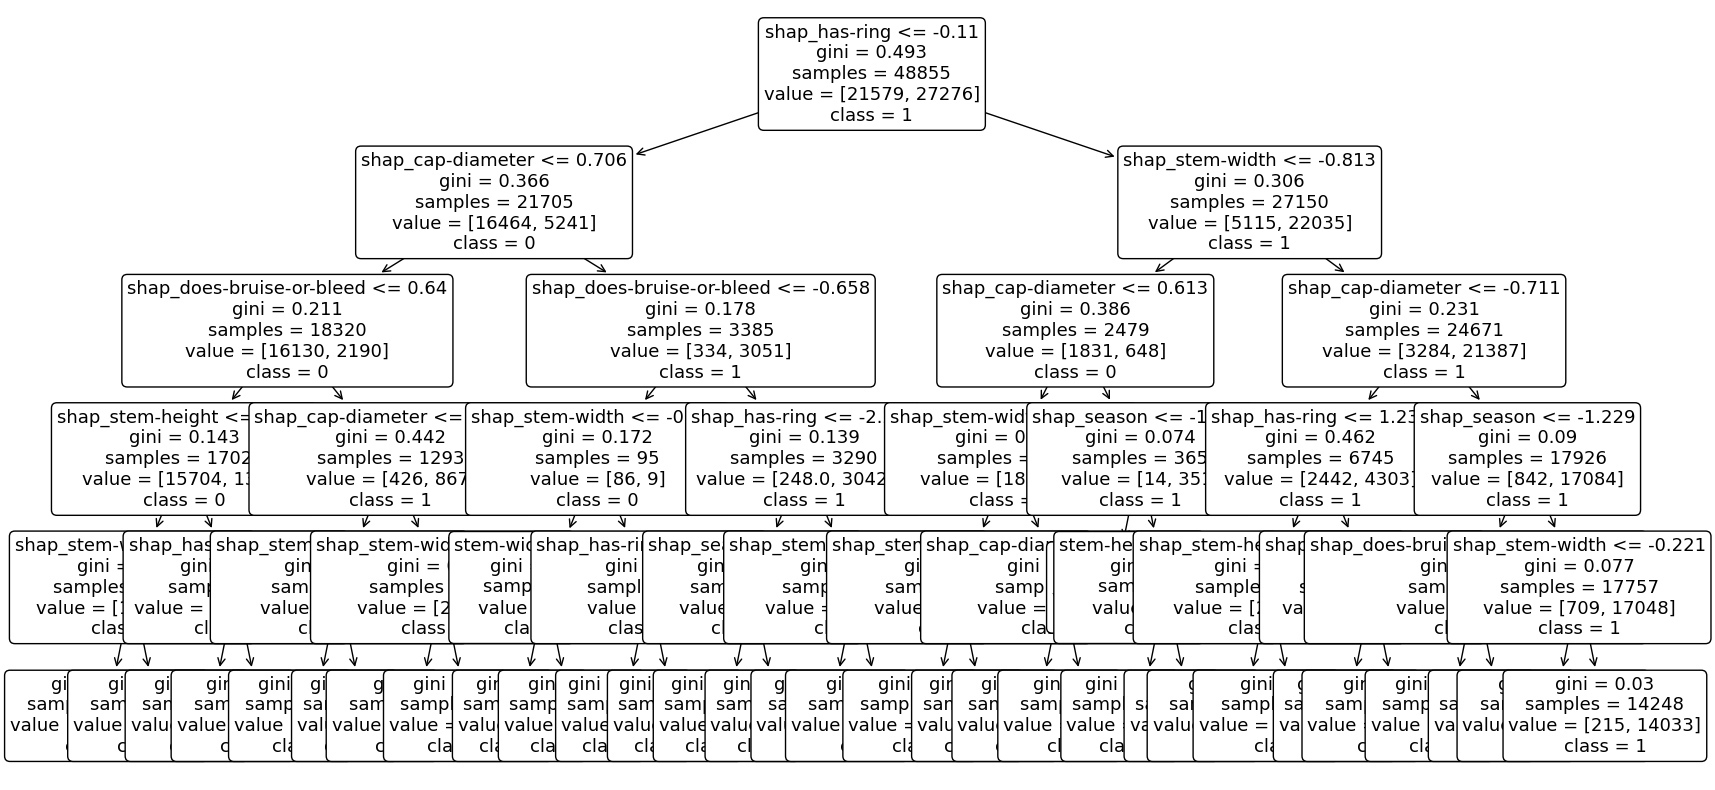

In [63]:
feature_names = [  'stem-width',
                   'stem-height',
                   'cap-diameter',
                   'has-ring',
                   'does-bruise-or-bleed',
                   'season']
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
# Visualize the decision tree
plt.figure(figsize=(20, 10))
# Combine original feature names and SHAP feature names
feature_names = list(X.columns) + [f'shap_{feature_names[i]}' for i in range(shap_values_array.shape[1])]

plot_tree(shallow_model,max_depth=5, fontsize=13, filled=False, rounded=True, feature_names=feature_names, class_names=np.unique(y).astype(str))
plt.show()

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Plot the decision tree
plt.figure(figsize=(20,10))  # Adjust the figure size as needed
plot_tree(shallow_model, max_depth=3,filled=False, feature_names=['stem-height','stem-width'], class_names=['e','p'], rounded=True,fontsize=12)
plt.show()

In [11]:
augmented_X_train

array([[ 2.02000000e+02,  0.00000000e+00,  2.43000000e+02, ...,
        -2.60952703e+00,  1.30117383e+00,  1.91749033e-01],
       [ 4.19000000e+02,  0.00000000e+00,  5.33000000e+02, ...,
         2.22672166e+00, -4.42770076e-01,  3.73001607e-01],
       [ 7.24000000e+02,  0.00000000e+00,  5.00000000e+02, ...,
         2.95720759e+00, -1.26331169e-01, -4.51889004e-01],
       ...,
       [ 1.18300000e+03,  0.00000000e+00,  9.69000000e+02, ...,
        -8.07555978e-01,  2.30523783e-01,  2.07026566e-01],
       [ 6.33000000e+02,  1.00000000e+00,  5.33000000e+02, ...,
        -5.03125903e-01, -4.25449977e-02, -8.07934185e-02],
       [ 6.67000000e+02,  0.00000000e+00,  5.20000000e+01, ...,
         1.42218525e-01,  1.25129930e-01,  5.43521643e-01]])

In [ ]:
shap_values_test = explainer.shap_values(X_test)

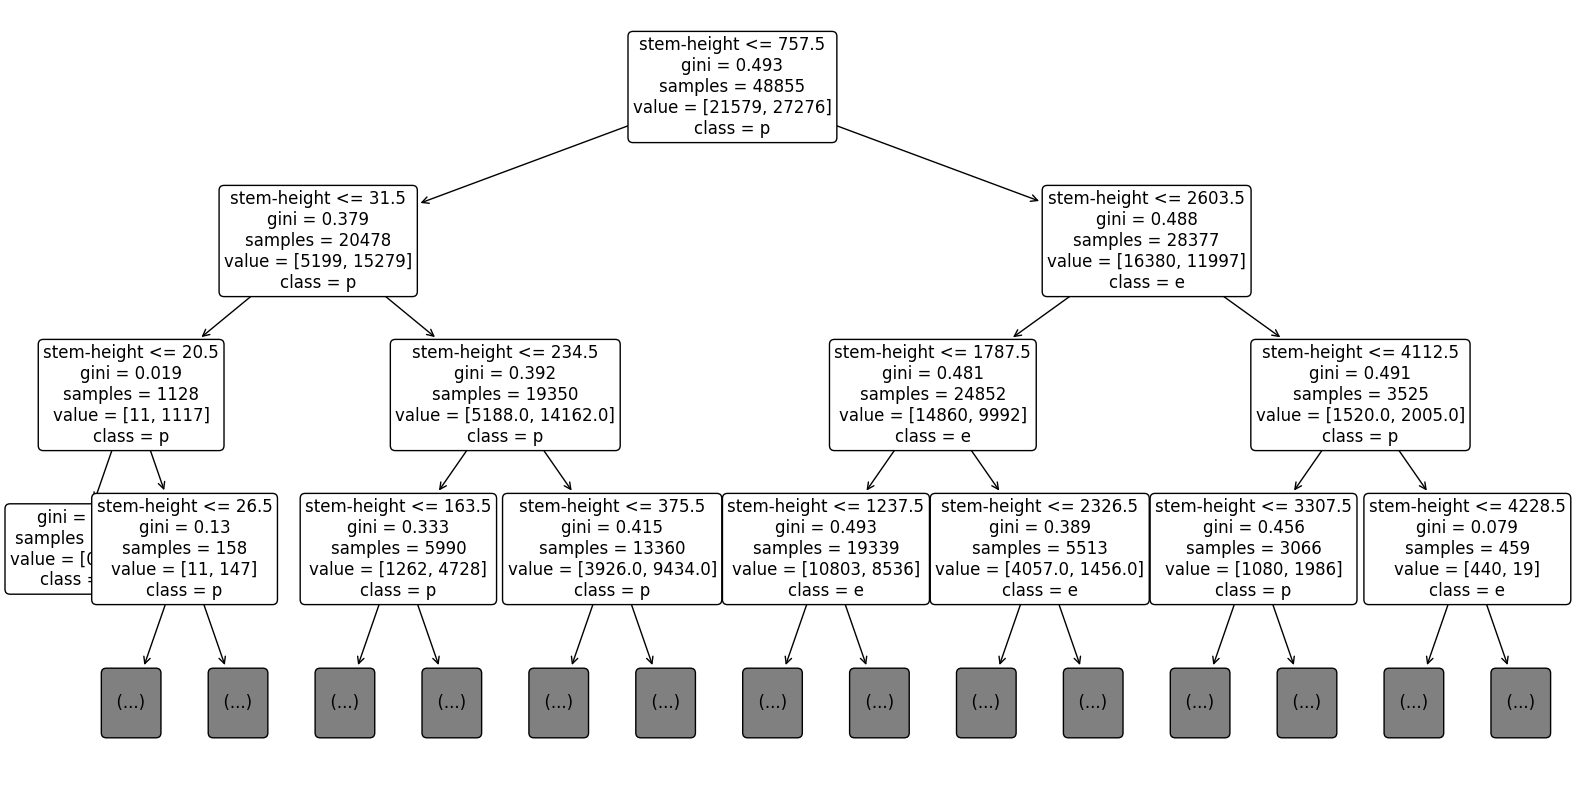

In [35]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Plot the decision tree
plt.figure(figsize=(20,10))  # Adjust the figure size as needed
plot_tree(shallow_model, max_depth=3,filled=False, feature_names=['stem-height','stem-width'], class_names=['e','p'], rounded=True,fontsize=12)
plt.show()

In [25]:
feature_names = X.columns.tolist()

# 打印特征名称列表
print("Feature Names List:")
print(feature_names)

Feature Names List:
['cap-diameter', 'does-bruise-or-bleed', 'stem-height', 'stem-width', 'has-ring', 'season']


In [30]:
import joblib
# 保存模型到本地文件
joblib.dump(model, 'xgb_model.joblib')

['xgb_model.joblib']

In [65]:
import shap
explainer = shap.Explainer(model, X_train)
instance = X_train.iloc[0]
shap_values = explainer(X_train)

100%|===================| 48844/48855 [01:24<00:00]        

In [64]:
shap_values

NameError: name 'shap_values' is not defined

[0]
[1]


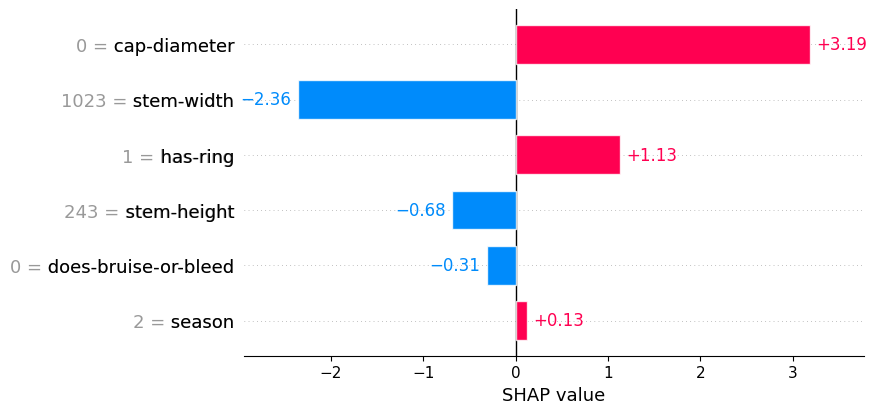

In [58]:
instance = X_train.iloc[0].copy()
print(model.predict([instance]))
instance['cap-diameter'] = 0
shap_value = explainer(instance)
print(model.predict([instance]))
shap.plots.bar(shap_value)

In [65]:
from sklearn.tree import DecisionTreeRegressor, export_text
# 计算 SHAP 值
shap_values = explainer.shap_values(X_train)

# 确保 SHAP 值的形状与 X_train 的样本数一致
if len(shap_values) != len(X_train):
    raise ValueError("The shape of SHAP values does not match the number of samples in X_train")

# 使用 SHAP 值计算每个样本的 SHAP 值之和
X_train_with_shap = X_train.copy()
X_train_with_shap['shap_value'] = np.abs(shap_values).sum(axis=1)

# 训练决策树回归模型
tree_model = DecisionTreeRegressor(max_depth=3)
tree_model.fit(X_train, X_train_with_shap['shap_value'])

# 提取并打印规则
rules = export_text(tree_model, feature_names=list(X_train.columns))
print("Extracted Rules from Decision Tree:")
print(rules)

# 基于规则生成注释
def generate_rule_based_annotations(instance, tree_model, feature_names):
    # 获取特征的值
    instance_values = instance.values.reshape(1, -1)
    decision_path = tree_model.decision_path(instance_values)
    
    rules_applied = []
    feature_index = tree_model.tree_.feature
    threshold = tree_model.tree_.threshold
    node_indicator = decision_path.indices
    
    for node_id in node_indicator:
        if feature_index[node_id] != -2:
            feature = feature_names[feature_index[node_id]]
            rule_value = instance[feature]
            rule_threshold = threshold[node_id]
            if rule_value <= rule_threshold:
                rules_applied.append(f"{feature} <= {rule_threshold:.2f}")
            else:
                rules_applied.append(f"{feature} > {rule_threshold:.2f}")

    return rules_applied

# 获取某个实例
instance_index = 0
instance = X_train.iloc[instance_index]

# 生成基于规则的注释
annotations = generate_rule_based_annotations(instance, tree_model, list(X_train.columns))
print("\nGenerated Annotations for the Instance:")
for annotation in annotations:
    print(annotation)

100%|===================| 48785/48855 [01:23<00:00]        

Extracted Rules from Decision Tree:
|--- stem-height <= 81.50
|   |--- stem-height <= 4.50
|   |   |--- season <= 2.50
|   |   |   |--- value: [10.91]
|   |   |--- season >  2.50
|   |   |   |--- value: [12.32]
|   |--- stem-height >  4.50
|   |   |--- season <= 2.50
|   |   |   |--- value: [9.25]
|   |   |--- season >  2.50
|   |   |   |--- value: [10.42]
|--- stem-height >  81.50
|   |--- cap-diameter <= 1120.50
|   |   |--- has-ring <= 0.50
|   |   |   |--- value: [4.03]
|   |   |--- has-ring >  0.50
|   |   |   |--- value: [5.40]
|   |--- cap-diameter >  1120.50
|   |   |--- stem-width <= 2923.50
|   |   |   |--- value: [5.89]
|   |   |--- stem-width >  2923.50
|   |   |   |--- value: [7.70]


Generated Annotations for the Instance:
stem-height > 81.50
cap-diameter <= 1120.50
has-ring > 0.50


/mnt/ssd2/yifan/miniconda3/envs/llama/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


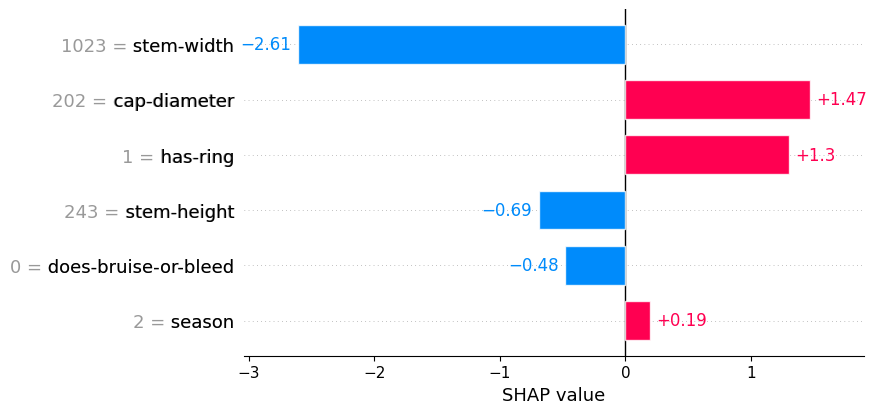

In [40]:
shap.plots.bar(shap_values[0])

In [7]:
max_abs_shap_value = np.max(np.abs([value.values for value in shap_values]))
print("max_abs_shap_value",max_abs_shap_value)

max_abs_shap_value 8.049500501404982


In [59]:
index = 0  # 选择第一个实例，你可以根据需要选择其他实例
instance = X_train.iloc[index]
instance_shap_values = shap_values[index]

In [61]:
instance_shap_values

0.84357819

In [60]:
# 计算每个特征的 SHAP 值
instance_feature_importance = pd.DataFrame(list(zip(X_train.columns, instance_shap_values.values)), columns=['feature', 'importance'])
instance_feature_importance = instance_feature_importance.sort_values(by='importance', ascending=False, key=abs)
print(instance_feature_importance)


AttributeError: 'numpy.float64' object has no attribute 'values'

In [56]:
# 输入数据
features = ['cap-diameter', 'does-bruise-or-bleed', 'gill-color', 'stem-height', 'stem-width', 'has-ring', 'season']
shap_values = np.array([0.84357819, -0.32757508, -0.48504226, -0.88088634, -1.54990394, 0.98807072, 0.02482514])
data = {
    'cap-diameter': 202,
    'does-bruise-or-bleed': False,
    'gill-color': 7,
    'stem-height': 243,
    'stem-width': 1023,
    'has-ring': True,
    'season': 'summer'
}

# 生成所有可能的关系
def generate_relations(features, shap_values):
    relations = []
    # 单一特征关系
    for i, (feature, shap_value) in enumerate(zip(features, shap_values)):
        relations.append((f"{feature} leads to", shap_value))
    
    # 组合特征关系
    for comb in itertools.combinations(range(len(features)), 2):
        feature_comb = [features[i] for i in comb]
        shap_value_comb = [shap_values[i] for i in comb]
        combined_shap_value = sum(shap_value_comb) / len(shap_value_comb)
        relations.append((f"{' and '.join(feature_comb)} lead to A{comb[0]+1} and A{comb[1]+1}", combined_shap_value))
    
    return relations
relations = generate_relations(features,shap_values)

In [58]:
# 生成文字注释
def generate_annotations(important_relations):
    annotations = []
    for relation in important_relations:
        annotations.append(f"Relation: {relation[0]} influence: {relation[1]:.3f}")
    return annotations

generate_annotations(relations)

['Relation: cap-diameter leads to influence: 0.844',
 'Relation: does-bruise-or-bleed leads to influence: -0.328',
 'Relation: gill-color leads to influence: -0.485',
 'Relation: stem-height leads to influence: -0.881',
 'Relation: stem-width leads to influence: -1.550',
 'Relation: has-ring leads to influence: 0.988',
 'Relation: season leads to influence: 0.025',
 'Relation: cap-diameter and does-bruise-or-bleed lead to A1 and A2 influence: 0.258',
 'Relation: cap-diameter and gill-color lead to A1 and A3 influence: 0.179',
 'Relation: cap-diameter and stem-height lead to A1 and A4 influence: -0.019',
 'Relation: cap-diameter and stem-width lead to A1 and A5 influence: -0.353',
 'Relation: cap-diameter and has-ring lead to A1 and A6 influence: 0.916',
 'Relation: cap-diameter and season lead to A1 and A7 influence: 0.434',
 'Relation: does-bruise-or-bleed and gill-color lead to A2 and A3 influence: -0.406',
 'Relation: does-bruise-or-bleed and stem-height lead to A2 and A4 influence:

In [40]:
y_pred = model.predict([instance])

In [62]:
import shap
import matplotlib.pyplot as plt
# Compute SHAP values
explainer = shap.Explainer(model, X_train)

In [76]:
index = 100
instance = X_train.iloc[index]
instance_shap_values = explainer(instance)
# 计算每个特征的 SHAP 值
instance_feature_importance = pd.DataFrame(list(zip(X_train.columns, instance_shap_values.values)), columns=['feature', 'importance'])
instance_feature_importance = instance_feature_importance.sort_values(by='importance', ascending=False, key=abs)

from copy import deepcopy

# 初始预测
initial_prediction = model.predict([instance])[0]

# 保留特征的重要性阈值（可以调整）
importance_threshold = 1

# 逐步移除不重要的特征
current_instance = deepcopy(instance)
removed_features = []

for feature in instance_feature_importance['feature']:
    if abs(instance_feature_importance[instance_feature_importance['feature'] == feature]['importance'].values[0]) < importance_threshold:
        current_instance = current_instance.drop(labels=[feature])
        removed_features.append(feature)
        current_instance[feature] = 0  # 将移除的特征值设为0或其他合理默认值
        
        current_prediction = model.predict([current_instance])[0]
        print("current_prediction",current_prediction,initial_prediction)
        
        print(f'Removed feature: {feature}, Prediction: {current_prediction}')
        
        if current_prediction != initial_prediction:
            # 如果移除该特征后预测发生变化，则停止移除
            break

print(f'Final retained features: {current_instance.index}')
print(f'Removed features: {removed_features}')


current_prediction 1 1
Removed feature: stem-width, Prediction: 1
current_prediction 1 1
Removed feature: stem-height, Prediction: 1
current_prediction 1 1
Removed feature: does-bruise-or-bleed, Prediction: 1
current_prediction 1 1
Removed feature: cap-diameter, Prediction: 1
current_prediction 1 1
Removed feature: gill-color, Prediction: 1
current_prediction 1 1
Removed feature: has-ring, Prediction: 1
current_prediction 1 1
Removed feature: season, Prediction: 1
Final retained features: Index(['stem-width', 'stem-height', 'does-bruise-or-bleed', 'cap-diameter',
       'gill-color', 'has-ring', 'season'],
      dtype='object')
Removed features: ['stem-width', 'stem-height', 'does-bruise-or-bleed', 'cap-diameter', 'gill-color', 'has-ring', 'season']


In [17]:
# 1. 一致性检查
# 检查 SHAP 值与模型预测的一致性
consistent = True
for i in range(5):  # 检查前 5 个样本
    original_prediction = model.predict([X_train.iloc[i]])
    shap_sum = shap_values[i].values.sum() + shap_values[i].base_values
    print(f"Original prediction: {original_prediction}, SHAP sum: {shap_sum}")
    # if not np.isclose(original_prediction, shap_sum, atol=1e-5):
    #     consistent = False
    #     print(f"Inconsistency found at index {i}: original_prediction={original_prediction}, shap_sum={shap_sum}")


# 2. 特征重要性比较
# 比较 SHAP 值和模型特征重要性
# shap_importance = np.abs(shap_values).mean(axis=0)
# model_importance = model.feature_importances_
# print("SHAP feature importance:", shap_importance)
# print("Model feature importance:", model_importance)

Original prediction: [0], SHAP sum: -0.8933287033969306
Original prediction: [1], SHAP sum: 6.863001901766599
Original prediction: [1], SHAP sum: 4.098916776258463
Original prediction: [1], SHAP sum: 4.1068601173932775
Original prediction: [0], SHAP sum: -5.470343426329585


In [21]:
shap_values.shape

(48855, 11)

In [24]:
import pickle
# 保存 shap_values 到本地文件
with open('shap_values.pkl', 'wb') as f:
    pickle.dump(shap_values, f)

In [26]:
# 从本地文件加载 shap_values
with open('shap_values.pkl', 'rb') as f:
    shap_values = pickle.load(f)

In [27]:
y_pred_ = model.predict(X_train)
y_pred_[0]

0

In [29]:
shap_values[0]

.values =
array([ 1.48727603, -0.91146642, -0.89171849, -0.30242687, -0.07896475,
       -0.18821719, -1.45066395, -0.75289296,  1.27687627,  0.05393288,
        0.08899657])

.base_values =
0.7759401783512085

.data =
array([ 202,    6,   10,    0,    7,  243, 1023,   11,    1,    1,    2])

In [41]:
shap_values[1]

.values =
-0.32757507655303925

.base_values =
0.45463654815787025

.data =
0

In [36]:
# 找到全局最大绝对值
max_abs_shap_value = np.max(np.abs([value.values for value in shap_values]))

In [37]:
max_abs_shap_value

6.237330045986455

In [ ]:
max_abs_shap_value

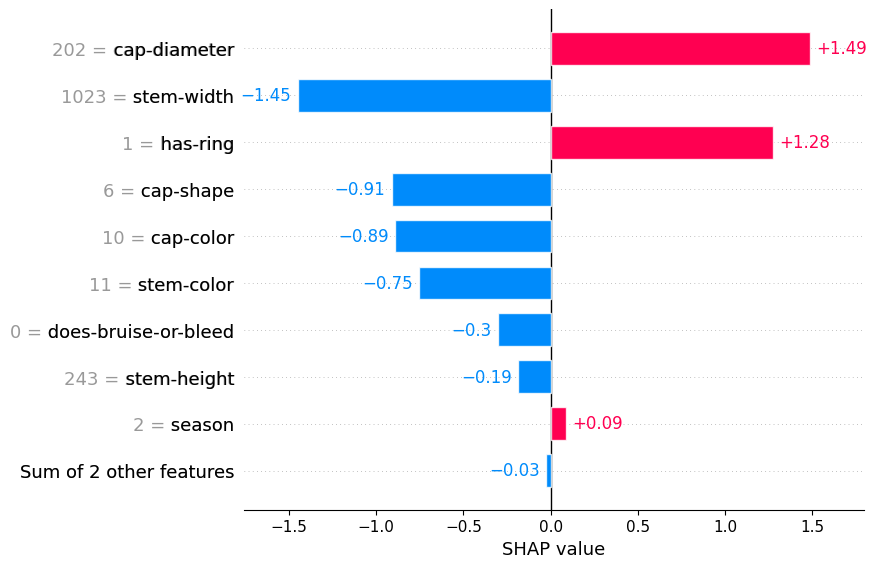

In [28]:
shap.plots.bar(shap_values[0])

In [42]:
# 创建LIME解释器
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['edible', 'poisonous'],
    mode='classification'
)

# 选择一个实例进行解释
i = 17  # 可选择任意测试集中的索引
exp = explainer.explain_instance(X_test.iloc[i], model.predict_proba, num_features=10)

# 显示解释
exp.show_in_notebook(show_table=True)


/mnt/ssd2/yifan/miniconda3/envs/llama/lib/python3.12/site-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/mnt/ssd2/yifan/miniconda3/envs/llama/lib/python3.12/site-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/mnt/ssd2/yifan/miniconda3/envs/llama/lib/python3.12/site-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labe

In [119]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Identify categorical and numerical features
categorical_features = ['does-bruise-or-bleed', 'has-ring', 'season']
numerical_features = [col for col in X_train.columns if col not in categorical_features]

# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Create the multi-output regressor
regressor = MultiOutputRegressor(DecisionTreeRegressor(max_depth=5, min_samples_split=10, min_samples_leaf=5, random_state=42))

# Create the pipeline with preprocessing and the multi-output regressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regressor)
])

# Train the model
pipeline.fit(X_train, shap_values)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['cap-diameter',
                                                   'stem-height',
                                                   'stem-width']),
                                                 ('cat', OneHotEncoder(),
                                                  ['does-bruise-or-bleed',
                                                   'has-ring', 'season'])])),
                ('regressor',
                 MultiOutputRegressor(estimator=DecisionTreeRegressor(max_depth=5,
                                                                      min_samples_leaf=5,
                                                                      min_samples_split=10,
                                                                      random_state=42)))])

In [126]:
# Extract feature names after preprocessing
onehot_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numerical_features, onehot_feature_names])

# Extract rules from each decision tree
for i, estimator in enumerate(regressor.estimators_):
    feature_name = f'Feature {i}' if not hasattr(shap_values, 'columns') else shap_values.columns[i]
    print(f"Rules for predicting SHAP value of {feature_name}:\n")
    rules = export_text(estimator, feature_names=list(all_feature_names))
    print(rules)
    print("\n")

Rules for predicting SHAP value of Feature 0:

|--- stem-width <= -0.90
|   |--- cap-diameter <= -1.34
|   |   |--- does-bruise-or-bleed_1 <= 0.50
|   |   |   |--- stem-height <= -1.06
|   |   |   |   |--- has-ring_0 <= 0.50
|   |   |   |   |   |--- value: [2.73]
|   |   |   |   |--- has-ring_0 >  0.50
|   |   |   |   |   |--- value: [0.79]
|   |   |   |--- stem-height >  -1.06
|   |   |   |   |--- stem-height <= -0.75
|   |   |   |   |   |--- value: [3.22]
|   |   |   |   |--- stem-height >  -0.75
|   |   |   |   |   |--- value: [4.20]
|   |   |--- does-bruise-or-bleed_1 >  0.50
|   |   |   |--- season_0 <= 0.50
|   |   |   |   |--- cap-diameter <= -1.36
|   |   |   |   |   |--- value: [0.28]
|   |   |   |   |--- cap-diameter >  -1.36
|   |   |   |   |   |--- value: [0.45]
|   |   |   |--- season_0 >  0.50
|   |   |   |   |--- stem-height <= -0.51
|   |   |   |   |   |--- value: [0.35]
|   |   |   |   |--- stem-height >  -0.51
|   |   |   |   |   |--- value: [0.08]
|   |--- cap-diamet

In [131]:
# Generate natural language explanations
def generate_natural_language_explanation(tree, feature_names):
    rules = export_text(tree, feature_names=feature_names).split('\n')
    explanations = []
    for rule in rules:
        if 'cap-diameter' in rule:
            rule_parts = rule.split()
            feature = rule_parts[1]
            threshold = rule_parts[3]
            operator = '<=' if '<=' in rule_parts else '>'
            explanations.append(f"If {feature} {operator} {threshold}, then the SHAP value is affected.")
    return explanations

In [132]:
# Generate explanations for each SHAP value prediction
for i, estimator in enumerate(regressor.estimators_):
    feature_name = f'Feature {i}' if not hasattr(shap_values, 'columns') else shap_values.columns[i]
    print(f"Natural language explanations for SHAP value of {feature_name}:\n")
    explanations = generate_natural_language_explanation(estimator, list(all_feature_names))
    for explanation in explanations:
        print(explanation)
    print("\n")

Natural language explanations for SHAP value of Feature 0:

If |--- <= <=, then the SHAP value is affected.
If | <= |, then the SHAP value is affected.
If | > |, then the SHAP value is affected.
If |--- > >, then the SHAP value is affected.
If | <= |, then the SHAP value is affected.
If | > |, then the SHAP value is affected.
If | <= |, then the SHAP value is affected.
If | > |, then the SHAP value is affected.
If | <= |---, then the SHAP value is affected.
If | > |---, then the SHAP value is affected.
If | <= cap-diameter, then the SHAP value is affected.
If | <= |---, then the SHAP value is affected.
If | > |---, then the SHAP value is affected.
If | > cap-diameter, then the SHAP value is affected.
If | <= cap-diameter, then the SHAP value is affected.
If | <= |, then the SHAP value is affected.
If | > |, then the SHAP value is affected.
If | > cap-diameter, then the SHAP value is affected.
If | <= |---, then the SHAP value is affected.
If | > |---, then the SHAP value is affected.

